<a href="https://colab.research.google.com/github/BernieT7/trade/blob/main/Screen_method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import yfinance as yf  # 引入 yfinance 庫，用於下載股票數據
import numpy as np  # 引入 numpy 庫，用於數值計算
import pandas as pd  # 引入 pandas 庫，用於數據處理
import datetime as dt
import matplotlib.pyplot as plt

In [2]:
# 定義計算年複合增長率（CAGR）的函數
def get_CAGR(DF):
  df = DF.copy()
  df["cum return"] = (1 + df["mon_return"]).cumprod()  # 計算累積收益率
  n = len(df)/12
  CAGR = (df["cum return"].iloc[-1])**(1/n) - 1  # 計算 CAGR
  return CAGR

# 定義計算年度波動率的函數
def get_volatility(DF):
  df = DF.copy()  # 複製數據
  vol = df["mon_return"].std() * np.sqrt(12)  # 計算年度波動率
  return vol

# 定義計算夏普比率（Sharpe Ratio）的函數
def get_sharpe(DF, rf):
  df = DF.copy()
  sharpe = (get_CAGR(df) - rf) / get_volatility(df)  # 計算夏普比率
  return sharpe

# 定義計算最大回撤（MDD）的函數
def get_MDD(DF):
  df = DF.copy()
  df["cum return"] = (1 + df["mon_return"]).cumprod()  # 計算累積收益率
  df["max cum return"] = df["cum return"].cummax()  # 計算累積收益率中的最大值
  df["drawdown"] = df["max cum return"] - df["cum return"]  # 計算回撤
  MDD = (df["drawdown"]/df["max cum return"]).max()  # 計算最大回撤
  return MDD

# 定義計算卡馬比率（Calmar Ratio）的函數
def get_calmar(DF):
  df = DF.copy()
  cal = get_CAGR(df) / get_MDD(df)  # 卡馬比率 = CAGR / 最大回撤
  return cal

In [3]:
stocks = [
    "FANG", "AMAT", "LRCX", "PCAR", "PYPL", "LIN", "XEL",
    "AEP", "CEG", "EXC",
    "CSX", "ODFL", "DASH", "FAST",
    "MAR", "BKNG", "SBUX", "WBD", "ABNB", "CTAS", "CMCSA", "CHTR",
    "REGN", "GILD", "MRNA", "IDXX", "ILMN", "BIIB", "AZN", "VRTX",
    "AMGN", "GEHC", "ISRG", "DXCM",
    "TMUS", "SNPS", "ADSK", "TTD", "TTWO", "PANW", "META", "EA",
    "ZS", "NFLX", "TEAM", "DDOG", "ROP", "ADP", "INTU", "MDB",
    "PAYX", "CRWD", "ADBE", "GOOGL", "CDW", "CTSH", "FTNT", "CSGP",
    "CDNS", "VRSK", "GOOG", "ANSS", "MSFT",
    "ORLY", "MELI", "DLTR", "COST", "CPRT", "LULU", "ROST",
    "PDD", "AMZN",
    "CSCO", "TXN", "AMD", "NVDA", "ADI", "ASML", "INTC",
    "NXPI", "QCOM", "MU", "MCHP", "GFS", "ON", "KLAC",
    "HON", "AAPL", "AVGO", "ARM", "TSLA",
    "PEP", "MDLZ", "KDP", "MNST", "KHC", "CCEP"
]

In [4]:
ohlc_data = {}  # 初始化空字典，用於存儲OHLC數據
start = dt.datetime.today() - dt.timedelta(1825)  # 設定開始日期，五年(1825天)前
end = dt.datetime.today()  # 設定結束日期，今天

# 循環下載所有股票的數據
for ticker in stocks:
  temp = yf.download(ticker, start=start, end=end, interval="1mo")  # 下載股票數據，間隔為1個月
  temp.dropna(how="any", inplace=True)  # 刪除包含NA的行
  ohlc_data[ticker] = temp  # 將數據存入字典

stocks = ohlc_data.keys()  # 獲取所有股票代碼

return_df = pd.DataFrame()  # 初始化空的DataFrame，用於存儲收益率數據
for ticker in stocks:
  return_df[ticker] = ohlc_data[ticker]["Adj Close"].pct_change()  # 計算每個股票的收益率
df = return_df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [5]:
# 定義投資組合再平衡函數
def portfolio_rebalancing(DF, pos_num, x):
  df = DF.copy()  # 複製數據
  portfolios = []  # 初始化空列表，用於存儲投資組合
  hist_portfolios = []
  monthly_return = [0]  # 初始化月收益率列表
  for i in range(len(df)):  # 遍歷每個月
    if len(portfolios) != 0:  # 如果投資組合不為空
      monthly_return.append(df[portfolios].iloc[i, :].mean())  # 計算當月投資組合的平均收益率
      bad_stocks = df[portfolios].iloc[i, :].sort_values()[:x].index.values.tolist()  # 找出表現最差的股票
      portfolios = [t for t in portfolios if t not in bad_stocks]  # 從投資組合中移除表現最差的股票
    fill = pos_num - len(portfolios)  # 計算需要補充的股票數量
    none_selected = [t for t in stocks if t not in portfolios]  # 找出未被選中的股票
    good_stocks = df[none_selected].iloc[i, :].sort_values(ascending=False)[:fill].index.values.tolist()  # 找出表現最好的股票
    portfolios = portfolios + good_stocks  # 將表現最好的股票加入投資組合
    hist_portfolios.append(portfolios)
  monthly_return_df = pd.DataFrame(np.array(monthly_return), columns=["mon_return"])  # 將月收益率列表轉換為DataFrame
  return monthly_return_df, hist_portfolios  # 返回月收益率DataFrame

[*********************100%***********************]  1 of 1 completed


0.23612032915938075
0.9902973978703271
0.25536290168883935


[*********************100%***********************]  1 of 1 completed

0.9246461705980075

0.19921283258641087
0.7509342615566921
0.32967487210504803
0.6042705994375375


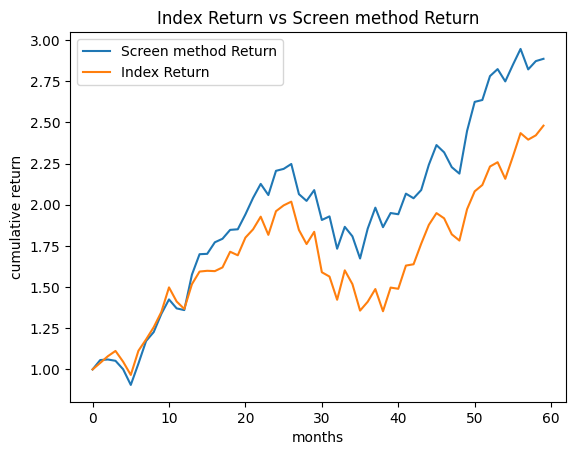

In [39]:
def get_risk_free_rate():
    # 使用 'TNX' 獲取 10 年期美國國債收益率 (數據來自雅虎財經)
    ticker = "^TNX"
    data = yf.download(ticker, period="1d")

    # 將收益率從百分比轉換為小數形式
    risk_free_rate = data['Close'].iloc[-1] / 100
    return risk_free_rate

pos_num = 40  # 設定投資組合中股票的數量
x = 20  # 設定需要剔除的表現最差的股票數量
rf = get_risk_free_rate()  # 設定無風險收益率

# 計算投資組合的CAGR、Sharpe Ratio、MDD和Calmar Ratio
print(get_CAGR(portfolio_rebalancing(return_df, pos_num, x)[0]))
print(get_sharpe(portfolio_rebalancing(return_df, pos_num, x)[0], rf))
print(get_MDD(portfolio_rebalancing(return_df, pos_num, x)[0]))
print(get_calmar(portfolio_rebalancing(return_df, pos_num, x)[0]))


NDX = yf.download("^NDX", start=start, end=end, interval="1mo")  # 下載道瓊指數數據
NDX["mon_return"] = NDX["Adj Close"].pct_change().fillna(0)  # 計算道瓊指數的月收益率並填充NA
# 計算道瓊指數的CAGR、Sharpe Ratio、MDD和Calmar Ratio
print()
print(get_CAGR(NDX))
print(get_sharpe(NDX, rf))
print(get_MDD(NDX))
print(get_calmar(NDX))

fig, ax = plt.subplots()  # 創建圖表
plt.plot((1+portfolio_rebalancing(return_df, pos_num, x)[0]).cumprod())  # 繪製投資組合的累積收益率
plt.plot((1+NDX["mon_return"].reset_index(drop=True)).cumprod())  # 繪製道瓊指數的累積收益率
plt.title("Index Return vs Screen method Return")  # 設置圖表標題
plt.ylabel("cumulative return")  # 設置Y軸標籤
plt.xlabel("months")  # 設置X軸標籤
ax.legend(["Screen method Return","Index Return"])  # 添加圖例

In [7]:
categories = {
    "非耐用消費品": [
        "PEP", "MDLZ", "KDP", "MNST", "KHC", "CCEP"
    ],
    "電子科技": [
        "CSCO", "TXN", "AMD", "NVDA", "ADI", "ASML", "INTC",
        "NXPI", "QCOM", "MU", "MCHP", "GFS", "ON", "KLAC",
        "HON", "AAPL", "AVGO", "ARM", "TSLA"
    ],
    "零售業": [
         "ORLY", "MELI", "DLTR", "COST", "CPRT", "LULU", "ROST",
         "PDD", "AMZN"
    ],
    "科技服務": [
        "TMUS", "SNPS", "ADSK", "TTD", "TTWO", "PANW", "META", "EA",
        "ZS", "NFLX", "TEAM", "DDOG", "ROP", "ADP", "INTU", "MDB",
        "PAYX", "CRWD", "ADBE", "GOOGL", "CDW", "CTSH", "FTNT", "CSGP",
        "CDNS", "VRSK", "GOOG", "ANSS", "MSFT"
    ],
    "健康科技": [
         "REGN", "GILD", "MRNA", "IDXX", "ILMN", "BIIB", "AZN", "VRTX",
         "AMGN", "GEHC", "ISRG", "DXCM"
    ],
    "消費者服務": [
        "MAR", "BKNG", "SBUX", "WBD", "ABNB", "CTAS", "CMCSA", "CHTR"
    ],
    "運輸": [
        "CSX", "ODFL", "DASH", "FAST"
    ],
    "其他行業": [
        "FANG", "AMAT", "LRCX", "PCAR", "PYPL", "LIN", "XEL",
        "AEP", "CEG", "EXC"
    ]
}

In [142]:
i = 1
for k,v in categories.items():
  print(i,".",k,": ", v)
  i+=1

1 . 非耐用消費品 :  ['PEP', 'MDLZ', 'KDP', 'MNST', 'KHC', 'CCEP']
2 . 電子科技 :  ['CSCO', 'TXN', 'AMD', 'NVDA', 'ADI', 'ASML', 'INTC', 'NXPI', 'QCOM', 'MU', 'MCHP', 'GFS', 'ON', 'KLAC', 'HON', 'AAPL', 'AVGO', 'ARM', 'TSLA']
3 . 零售業 :  ['ORLY', 'MELI', 'DLTR', 'COST', 'CPRT', 'LULU', 'ROST', 'PDD', 'AMZN']
4 . 科技服務 :  ['TMUS', 'SNPS', 'ADSK', 'TTD', 'TTWO', 'PANW', 'META', 'EA', 'ZS', 'NFLX', 'TEAM', 'DDOG', 'ROP', 'ADP', 'INTU', 'MDB', 'PAYX', 'CRWD', 'ADBE', 'GOOGL', 'CDW', 'CTSH', 'FTNT', 'CSGP', 'CDNS', 'VRSK', 'GOOG', 'ANSS', 'MSFT']
5 . 健康科技 :  ['REGN', 'GILD', 'MRNA', 'IDXX', 'ILMN', 'BIIB', 'AZN', 'VRTX', 'AMGN', 'GEHC', 'ISRG', 'DXCM']
6 . 消費者服務 :  ['MAR', 'BKNG', 'SBUX', 'WBD', 'ABNB', 'CTAS', 'CMCSA', 'CHTR']
7 . 運輸 :  ['CSX', 'ODFL', 'DASH', 'FAST']
8 . 其他行業 :  ['FANG', 'AMAT', 'LRCX', 'PCAR', 'PYPL', 'LIN', 'XEL', 'AEP', 'CEG', 'EXC']


In [41]:
# pos_num = 100
# x = round(pos_num/2)

limit_1 = round(len(categories["非耐用消費品"])/len(stocks)*pos_num)
limit_2 = round(len(categories["電子科技"])/len(stocks)*pos_num)
limit_3 = round(len(categories["零售業"])/len(stocks)*pos_num)
limit_4 = round(len(categories["科技服務"])/len(stocks)*pos_num)
limit_5 = round(len(categories["健康科技"])/len(stocks)*pos_num)
limit_6 = round(len(categories["消費者服務"])/len(stocks)*pos_num)
limit_7 = round(len(categories["運輸"])/len(stocks)*pos_num)
limit_8 = round(len(categories["其他行業"])/len(stocks)*pos_num)

limitation = {
    "非耐用消費品": round(len(categories["非耐用消費品"])/len(stocks)*pos_num),
    "電子科技": round(len(categories["電子科技"])/len(stocks)*pos_num),
    "零售業": round(len(categories["零售業"])/len(stocks)*pos_num),
    "科技服務": round(len(categories["科技服務"])/len(stocks)*pos_num),
    "健康科技": round(len(categories["健康科技"])/len(stocks)*pos_num),
    "消費者服務": round(len(categories["消費者服務"])/len(stocks)*pos_num),
    "運輸": round(len(categories["運輸"])/len(stocks)*pos_num),
    "其他行業": round(len(categories["其他行業"])/len(stocks)*pos_num)
}

print("realistic wieght: ")
print("非耐用消費品: ",limit_1)
print("電子科技: ",limit_2)
print("零售業: ",limit_3)
print("科技服務: ",limit_4)
print("健康科技: ",limit_5)
print("消費者服務: ",limit_6)
print("運輸: ",limit_7)
print("其他行業: ",limit_8)

realistic wieght: 
非耐用消費品:  2
電子科技:  8
零售業:  4
科技服務:  12
健康科技:  5
消費者服務:  3
運輸:  2
其他行業:  4


In [ ]:
portfolios_record = portfolio_rebalancing(return_df, pos_num, x)[1]
for port in portfolios_record:
  print(port)

In [ ]:
i = 1
record_dict={}
for port in portfolios_record:
  group1 = 0
  group2 = 0
  group3 = 0
  group4 = 0
  group5 = 0
  group6 = 0
  group7 = 0
  group8 = 0
  for ticker in port:
    if ticker in categories["非耐用消費品"]:
      group1 += 1
    elif ticker in categories["電子科技"]:
      group2 += 1
    elif ticker in categories["零售業"]:
      group3 += 1
    elif ticker in categories["科技服務"]:
      group4 += 1
    elif ticker in categories["健康科技"]:
      group5 += 1
    elif ticker in categories["消費者服務"]:
      group6 += 1
    elif ticker in categories["運輸"]:
      group7 += 1
    elif ticker in categories["其他行業"]:
      group8 += 1
  print(f"real situation{i}")
  print("非耐用消費品: ", group1)
  print("電子科技: ", group2)
  print("零售業: ", group3)
  print("科技服務: ", group4)
  print("健康科技: ", group5)
  print("消費者服務: ", group6)
  print("運輸: ", group7)
  print("其他行業: ", group8)
  record_dict[i] = [group1, group2, group3, group4, group5, group6, group7, group8]
  i += 1
record_df = pd.DataFrame(record_dict).T
record_df.columns = [["非耐用消費品", "電子科技", "零售業", "科技服務", "健康科技", "消費者服務", "運輸", "其他行業"]]

In [40]:
def diverserfied_portfolio_rebalancing(DF, pos_num, limitation):
  df = DF.copy()  # 複製數據
  portfolios = []  # 初始化空列表，用於存儲投資組合
  monthly_return = [0]  # 初始化月收益率列表
  hist_portfolios = []
  fill = {}
  for k, v in categories.items():
    fill[k] = limitation[k]
  for i in range(len(df)):  # 遍歷每個月
    if len(portfolios) != 0:  # 如果投資組合不為空
      monthly_return.append(df[portfolios].iloc[i, :].mean())  # 計算當月投資組合的平均收益率
      for k, v in categories.items():
        if limitation[k] == 1:
          stocks = [stock for stock in categories[k] if stock in portfolios]
          portfolios = [t for t in portfolios if t not in stocks]
          fill[k] = 1
        else:
          stocks = [stock for stock in categories[k] if stock in portfolios]
          bad_cat_stocks = df[stocks].iloc[i, :].sort_values()[: round(limitation[k]/2)].index.values.tolist()  # 找出表現最差的股票
          portfolios = [t for t in portfolios if t not in bad_cat_stocks]  # 從投資組合中移除表現最差的股票
          fill[k] = limitation[k] - round(limitation[k]/2)  # 計算需要補充的股票數量
    for k, v in categories.items():
      none_selected = [stock for stock in categories[k] if stock not in portfolios]  # 找出未被選中的股票
      good_stocks = df[none_selected].iloc[i, :].sort_values(ascending=False)[: fill[k]].index.values.tolist()  # 找出表現最好的股票
      portfolios = portfolios + good_stocks  # 將表現最好的股票加入投資組合
    hist_portfolios.append(portfolios)
  monthly_return_df = pd.DataFrame(np.array(monthly_return), columns=["mon_return"])  # 將月收益率列表轉換為DataFrame
  return monthly_return_df, hist_portfolios  # 返回月收益率DataFrame

In [42]:
# 計算投資組合的CAGR、Sharpe Ratio、MDD和Calmar Ratio
print("sceen method")
print(get_CAGR(portfolio_rebalancing(return_df, pos_num, x)[0]))
print(get_volatility(portfolio_rebalancing(return_df, pos_num, x)[0]))
print(get_sharpe(portfolio_rebalancing(return_df, pos_num, x)[0], rf))
print(get_MDD(portfolio_rebalancing(return_df, pos_num, x)[0]))
print(get_calmar(portfolio_rebalancing(return_df, pos_num, x)[0]))
# 計算投資組合的CAGR、Sharpe Ratio、MDD和Calmar Ratio
print("wieghted sceen method")
print(get_CAGR(diverserfied_portfolio_rebalancing(return_df, pos_num, limitation)[0]))
print(get_volatility(diverserfied_portfolio_rebalancing(return_df, pos_num, limitation)[0]))
print(get_sharpe(diverserfied_portfolio_rebalancing(return_df, pos_num, limitation)[0], rf))
print(get_MDD(diverserfied_portfolio_rebalancing(return_df, pos_num, limitation)[0]))
print(get_calmar(diverserfied_portfolio_rebalancing(return_df, pos_num, limitation)[0]))
NDX = yf.download("^NDX", start=start, end=end, interval="1mo")  # 下載道瓊指數數據
NDX["mon_return"] = NDX["Adj Close"].pct_change().fillna(0)  # 計算道瓊指數的月收益率並填充NA
# 計算道瓊指數的CAGR、Sharpe Ratio、MDD和Calmar Ratio
print("NDX")
print(get_CAGR(NDX))
print(get_volatility(NDX))
print(get_sharpe(NDX, rf))
print(get_MDD(NDX))
print(get_calmar(NDX))

sceen method
0.23612032915938075
0.2001422314313588
0.9902973978703271
0.25536290168883935
0.9246461705980075
wieghted sceen method
0.24532805617686826
0.19662747143160436
1.0548274689077133
0.24063415027075385


[*********************100%***********************]  1 of 1 completed

1.0195063996562124
NDX
0.19919619655111998
0.21478907726521632
0.750858472114179
0.32967487210504803
0.6042201374924561


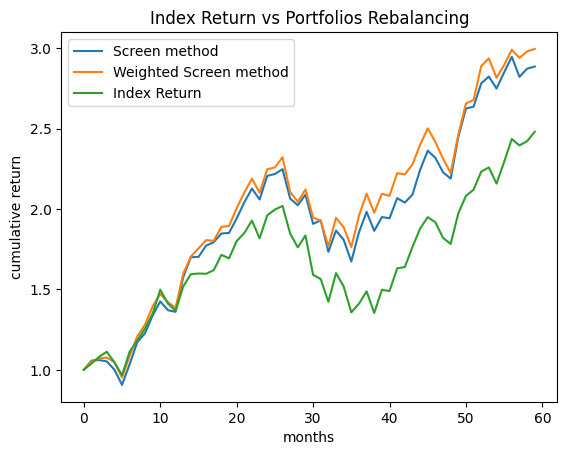

In [44]:
fig, ax = plt.subplots()  # 創建圖表
plt.plot((1+portfolio_rebalancing(return_df, pos_num, x)[0]).cumprod())  # 繪製投資組合的累積收益率
plt.plot((1+diverserfied_portfolio_rebalancing(return_df, pos_num, limitation)[0]).cumprod())
plt.plot((1+NDX["mon_return"].reset_index(drop=True)).cumprod())  # 繪製道瓊指數的累積收益率
plt.title("Index Return vs Portfolios Rebalancing")  # 設置圖表標題
plt.ylabel("cumulative return")  # 設置Y軸標籤
plt.xlabel("months")  # 設置X軸標籤
ax.legend(["Screen method", "Weighted Screen method", "Index Return"])  # 添加圖例

In [33]:
record = diverserfied_portfolio_rebalancing(return_df, pos_num, limitation)[1]

In [ ]:
for port in record:
  print(port)

In [ ]:
i = 1
re_dict={}
for port in record:
  group1 = 0
  group2 = 0
  group3 = 0
  group4 = 0
  group5 = 0
  group6 = 0
  group7 = 0
  group8 = 0
  for ticker in port:
    if ticker in categories["非耐用消費品"]:
      group1 += 1
    elif ticker in categories["電子科技"]:
      group2 += 1
    elif ticker in categories["零售業"]:
      group3 += 1
    elif ticker in categories["科技服務"]:
      group4 += 1
    elif ticker in categories["健康科技"]:
      group5 += 1
    elif ticker in categories["消費者服務"]:
      group6 += 1
    elif ticker in categories["運輸"]:
      group7 += 1
    elif ticker in categories["其他行業"]:
      group8 += 1
  print(f"real situation{i}")
  print("非耐用消費品: ", group1)
  print("電子科技: ", group2)
  print("零售業: ", group3)
  print("科技服務: ", group4)
  print("健康科技: ", group5)
  print("消費者服務: ", group6)
  print("運輸: ", group7)
  print("其他行業: ", group8)
  re_dict[i] = [group1, group2, group3, group4, group5, group6, group7, group8]
  i += 1
re_df = pd.DataFrame(re_dict).T
re_df.columns = [["非耐用消費品", "電子科技", "零售業", "科技服務", "健康科技", "消費者服務", "運輸", "其他行業"]]

In [35]:
pos_num = []
for i in range(1, 91):
  pos_num.append(i)

nonweight_NDX_CAGR_list=[]
nonweight_NDX_vol_list=[]
nonweight_NDX_SR_list=[]
weight_NDX_CAGR_list=[]
weight_NDX_vol_list=[]
weight_NDX_SR_list=[]
nonweight_weight_CAGR_list = []
nonweight_weight_vol_list = []
nonweight_weight_SR_list = []
for i in pos_num:
  x = round(i/2)
  limitation = {
    "非耐用消費品": round(len(categories["非耐用消費品"])/len(stocks)*i),
    "電子科技": round(len(categories["電子科技"])/len(stocks)*i),
    "零售業": round(len(categories["零售業"])/len(stocks)*i),
    "科技服務": round(len(categories["科技服務"])/len(stocks)*i),
    "健康科技": round(len(categories["健康科技"])/len(stocks)*i),
    "消費者服務": round(len(categories["消費者服務"])/len(stocks)*i),
    "運輸": round(len(categories["運輸"])/len(stocks)*i),
    "其他行業": round(len(categories["其他行業"])/len(stocks)*i)
  }
  # 計算投資組合的CAGR、Sharpe Ratio、MDD和Calmar Ratio
  nonweight_NDX_CAGR = get_CAGR(portfolio_rebalancing(return_df, i, x)[0]) - get_CAGR(NDX)
  nonweight_NDX_CAGR_list.append(nonweight_NDX_CAGR)
  nonweight_NDX_vol = get_volatility(portfolio_rebalancing(return_df, i, x)[0]) - get_volatility(NDX)
  nonweight_NDX_vol_list.append(nonweight_NDX_vol)
  nonweight_NDX_SR = get_sharpe(portfolio_rebalancing(return_df, i, x)[0], rf) - get_sharpe(NDX, rf)
  nonweight_NDX_SR_list.append(nonweight_NDX_SR)
  weight_NDX_CAGR = get_CAGR(diverserfied_portfolio_rebalancing(return_df, i, limitation)[0]) - get_CAGR(NDX)
  weight_NDX_CAGR_list.append(weight_NDX_CAGR)
  weight_NDX_vol = get_volatility(diverserfied_portfolio_rebalancing(return_df, i, limitation)[0]) - get_volatility(NDX)
  weight_NDX_vol_list.append(weight_NDX_vol)
  weight_NDX_SR = get_sharpe(diverserfied_portfolio_rebalancing(return_df, i, limitation)[0], rf) - get_sharpe(NDX, rf)
  weight_NDX_SR_list.append(weight_NDX_SR)
  nonweight_weight_CAGR = get_CAGR(diverserfied_portfolio_rebalancing(return_df, i, limitation)[0]) - get_CAGR(portfolio_rebalancing(return_df, i, x)[0])
  nonweight_weight_CAGR_list.append(nonweight_weight_CAGR)
  nonweight_weight_vol = get_volatility(diverserfied_portfolio_rebalancing(return_df, i, limitation)[0]) - get_volatility(portfolio_rebalancing(return_df, i, x)[0])
  nonweight_weight_vol_list.append(nonweight_weight_vol)
  nonweight_weight_SR = get_sharpe(diverserfied_portfolio_rebalancing(return_df, i, limitation)[0], rf) - get_sharpe(portfolio_rebalancing(return_df, i, x)[0], rf)
  nonweight_weight_SR_list.append(nonweight_weight_SR)

  # print("sceen method")
  # print(get_CAGR(portfolio_rebalancing(return_df, i, x)[0]))
  # print(get_volatility(portfolio_rebalancing(return_df, i, x)[0]))
  # print(get_sharpe(portfolio_rebalancing(return_df, i, x)[0], rf))
  # print(get_MDD(portfolio_rebalancing(return_df, i, x)[0]))
  # print(get_calmar(portfolio_rebalancing(return_df, i, x)[0]))
  # # 計算投資組合的CAGR、Sharpe Ratio、MDD和Calmar Ratio
  # print("wieghted sceen method")
  # print(get_CAGR(diverserfied_portfolio_rebalancing(return_df, i, limitation)[0]))
  # print(get_volatility(diverserfied_portfolio_rebalancing(return_df, i, limitation)[0]))
  # print(get_sharpe(diverserfied_portfolio_rebalancing(return_df, i, limitation)[0], rf))
  # print(get_MDD(diverserfied_portfolio_rebalancing(return_df, i, limitation)[0]))
  # print(get_calmar(diverserfied_portfolio_rebalancing(return_df, i, limitation)[0]))
  # NDX = yf.download("^NDX", start=start, end=end, interval="1mo")  # 下載道瓊指數數據
  # NDX["mon_return"] = NDX["Adj Close"].pct_change().fillna(0)  # 計算道瓊指數的月收益率並填充NA
  # # 計算道瓊指數的CAGR、Sharpe Ratio、MDD和Calmar Ratio
  # print("NDX")
  # print(get_CAGR(NDX))
  # print(get_volatility(NDX))
  # print(get_sharpe(NDX, rf))
  # print(get_MDD(NDX))
  # print(get_calmar(NDX))

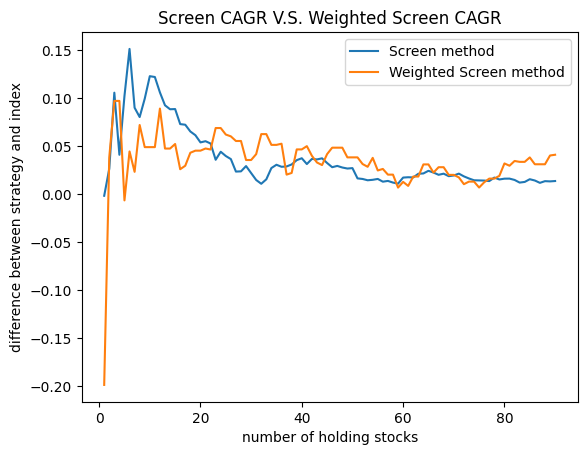

In [36]:
fig, ax = plt.subplots()  # 創建圖表
plt.plot(pos_num, nonweight_NDX_CAGR_list)
plt.plot(pos_num, weight_NDX_CAGR_list)
plt.title("Screen CAGR V.S. Weighted Screen CAGR")  # 設置圖表標題
plt.ylabel("difference between strategy and index")  # 設置Y軸標籤
plt.xlabel("number of holding stocks")  # 設置X軸標籤
ax.legend(["Screen method", "Weighted Screen method"])  # 添加圖例

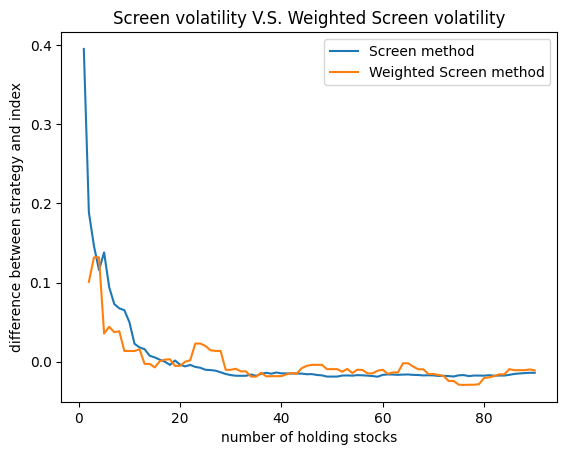

In [37]:
fig, ax = plt.subplots()  # 創建圖表
plt.plot(pos_num, nonweight_NDX_vol_list)
plt.plot(pos_num, weight_NDX_vol_list)
plt.title("Screen volatility V.S. Weighted Screen volatility")  # 設置圖表標題
plt.ylabel("difference between strategy and index")  # 設置Y軸標籤
plt.xlabel("number of holding stocks")  # 設置X軸標籤
ax.legend(["Screen method", "Weighted Screen method"])  # 添加圖例

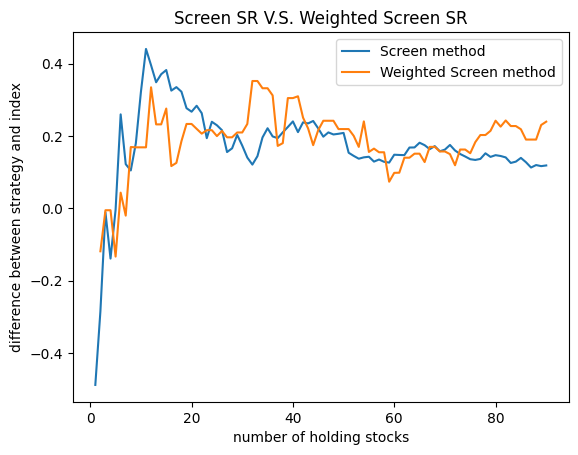

In [38]:
fig, ax = plt.subplots()  # 創建圖表
plt.plot(pos_num, nonweight_NDX_SR_list)
plt.plot(pos_num, weight_NDX_SR_list)
plt.title("Screen SR V.S. Weighted Screen SR")  # 設置圖表標題
plt.ylabel("difference between strategy and index")  # 設置Y軸標籤
plt.xlabel("number of holding stocks")  # 設置X軸標籤
ax.legend(["Screen method", "Weighted Screen method"])  # 添加圖例

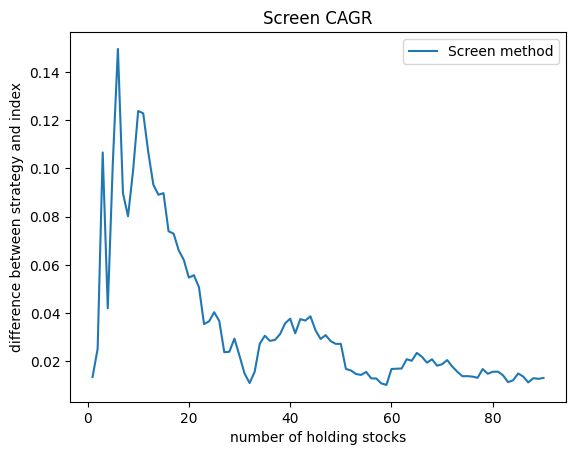

In [165]:
fig, ax = plt.subplots()  # 創建圖表
plt.plot(pos_num, nonweight_NDX_CAGR_list)
plt.title("Screen CAGR")  # 設置圖表標題
plt.ylabel("difference between strategy and index")  # 設置Y軸標籤
plt.xlabel("number of holding stocks")  # 設置X軸標籤
ax.legend(["Screen method"])  # 添加圖例

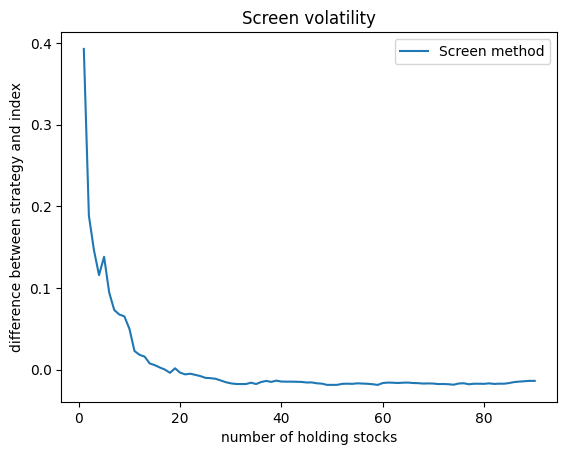

In [168]:
fig, ax = plt.subplots()  # 創建圖表
plt.plot(pos_num, nonweight_NDX_vol_list)
plt.title("Screen volatility")  # 設置圖表標題
plt.ylabel("difference between strategy and index")  # 設置Y軸標籤
plt.xlabel("number of holding stocks")  # 設置X軸標籤
ax.legend(["Screen method"])  # 添加圖例

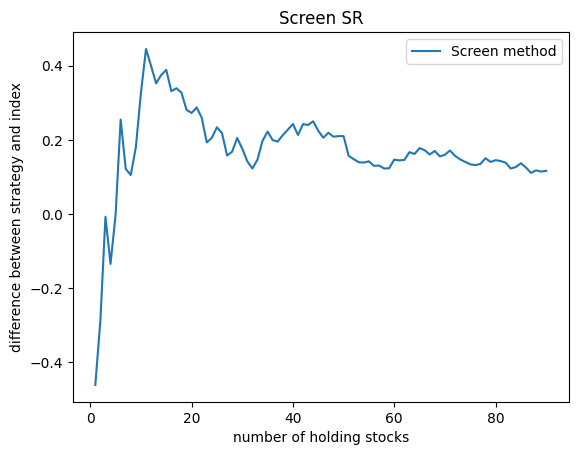

In [169]:
fig, ax = plt.subplots()  # 創建圖表
plt.plot(pos_num, nonweight_NDX_SR_list)
plt.title("Screen SR")  # 設置圖表標題
plt.ylabel("difference between strategy and index")  # 設置Y軸標籤
plt.xlabel("number of holding stocks")  # 設置X軸標籤
ax.legend(["Screen method"])  # 添加圖例

In [177]:
stocks = [
    "FANG", "AMAT", "LRCX", "PCAR", "PYPL", "LIN", "XEL",
    "AEP", "CEG", "EXC",
    "CSX", "ODFL", "DASH", "FAST",
    "MAR", "BKNG", "SBUX", "WBD", "ABNB", "CTAS", "CMCSA", "CHTR",
    "REGN", "GILD", "MRNA", "IDXX", "ILMN", "BIIB", "AZN", "VRTX",
    "AMGN", "GEHC", "ISRG", "DXCM",
    "TMUS", "SNPS", "ADSK", "TTD", "TTWO", "PANW", "META", "EA",
    "ZS", "NFLX", "TEAM", "DDOG", "ROP", "ADP", "INTU", "MDB",
    "PAYX", "CRWD", "ADBE", "GOOGL", "CDW", "CTSH", "FTNT", "CSGP",
    "CDNS", "VRSK", "GOOG", "ANSS", "MSFT",
    "ORLY", "MELI", "DLTR", "COST", "CPRT", "LULU", "ROST",
    "PDD", "AMZN",
    "CSCO", "TXN", "AMD", "NVDA", "ADI", "ASML", "INTC",
    "NXPI", "QCOM", "MU", "MCHP", "GFS", "ON", "KLAC",
    "HON", "AAPL", "AVGO", "TSLA",
    "PEP", "MDLZ", "KDP", "MNST", "KHC", "CCEP"
]